## 1. Topological Data Analysis for Financial Time Series - Early Warning System and Backtest

This notebook explores the application of Topological Data Analysis (TDA), specifically persistent homology and landscape norms, to financial time series. The goal is to develop an "early warning system" for potential price movements and to demonstrate a basic backtesting framework for a simple trading strategy based on TDA signals.
### 1a. Setup and Global Parameters

This section imports necessary libraries and defines global parameters for the TDA analysis and signal detection.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import yfinance as yf
from math import log, sqrt
import pandas as pd
import numpy as np
import gudhi as gd
from datetime import date
import matplotlib.pyplot as plt

# TDA Parameters
embedding_dim = 4
time_delay = 5
window_length = 10

# Spike Signal Detection Parameters
# MA_WINDOW: Window size for the long-term moving average.
MA_WINDOW = 20 # e.g., 20 days for the historical average comparison

# OFFSET: The number of days (including current day) to look back for the recent maximum.
OFFSET = 4    # e.g., max between d and d-4 days (a 5-day window including d)

# SPIKE_THRESHOLD_PCT_ABOVE_MA: The percentage by which the recent max must exceed the historical MA.
SPIKE_THRESHOLD_PCT_ABOVE_MA = 2 # e.g., recent max must be 10% above the historical MA

# Early Warning System Parameters
PREDICTION_WINDOW = 10 # How many periods *ahead* to look for price change after a signal

COOLDOWN_PERIOD = 10

# Backtesting Parameters
TRANSACTION_COST_BPS = 2 # Basis points per trade (e.g., 2 bps = 0.0002)

### 1b. Core TDA Functions

These functions handle the log return calculation, computation of landscape norms from Rips complexes, and the time-delay embedding process.

In [2]:
def log_return(data_series):
    """
    Computes the logarithmic returns of a financial time series.

    Args:
        data_series (pd.Series): A pandas Series of asset prices.

    Returns:
        pd.Series: A Series of logarithmic returns.
    """
    return ((data_series / data_series.shift())[1:]).apply(log)

def compute_norm(Z):
    """
    Computes different landscape norms (1-norm, 2-norm, inf-norm)
    from the 1-dimensional persistent homology of a Rips complex.

    Args:
        Z (list of lists/arrays): A list of embedded points (sliding window of time-delay coordinates).

    Returns:
        dict: A dictionary containing '1', '2', and 'inf' norms.
    """
    # Create Rips complex as simplex tree
    acZ = gd.RipsComplex(points=Z).create_simplex_tree(max_dimension=2)
    # Compute persistence in Z/2Z coefficient.
    dgmZ = acZ.persistence(homology_coeff_field=2)

    # Get 1-dimensional persistence intervals
    h1_intervals = acZ.persistence_intervals_in_dimension(1)

    # Calculate 1-norm of landscape of 1-d persistent homology
    # Based on the definition involving (y-x)/2 as height
    norm_1 = sum([((y - x) / 2)**2 for x, y in h1_intervals])

    # Calculate 2-norm (related to area under landscape function squared, often sqrt of sum of (y-x)^3/12)
    # The formula provided ((y-x)**3)/12 suggests integration, consistent with 2-norm definition.
    norm_2 = sqrt(sum([((y - x)**3) / 12 for x, y in h1_intervals]))

    # Calculate inf-norm (maximum height of landscape function)
    norm_inf = max([((y - x) / 2) for x, y in h1_intervals]) if len(h1_intervals) else 0

    return {'1': norm_1, '2': norm_2, 'inf': norm_inf}

def get_norms(log_returns_series, norm='1', embedding_dim=embedding_dim, time_delay=time_delay, window_length=window_length):
    """
    Computes a specified landscape norm for sliding windows of time-delay embedded log returns.

    Args:
        log_returns_series (pd.Series): Series of logarithmic returns.
        norm (str): The type of norm to compute ('1', '2', or 'inf').
        embedding_dim (int): The embedding dimension for Takens' embedding.
        time_delay (int): The time delay for Takens' embedding.
        window_length (int): The length of the sliding window for TDA computation.

    Returns:
        pd.Series: A Series of computed landscape norms, indexed by the end date of each window.

    Raises:
        ValueError: If an invalid norm type is specified.
    """
    if norm not in ['1', '2', 'inf']:
        raise ValueError(f"Norm must be '1','2', or 'inf'. Current norm: {norm}")

    series_len = len(log_returns_series)

    # Ensure enough data points for embedding and windowing
    min_len_required = (embedding_dim - 1) * time_delay + window_length
    if series_len < min_len_required:
        print(f"Warning: Not enough data points for TDA with current parameters. Need at least {min_len_required}, have {series_len}.")
        return pd.Series([], dtype=float) # Return empty series if not enough data

    # Time-delay embedding
    # Creates a list of points where each point is [r_t, r_{t+tau}, ..., r_{t+(d-1)tau}]
    time_delay_coord = []
    for i in range(series_len - (embedding_dim - 1) * time_delay):
        point = [log_returns_series.iloc[i + j * time_delay] for j in range(embedding_dim)]
        time_delay_coord.append(point)

    # Sliding windows over the time-delay embedded points
    Z_windows = []
    window_indices = []
    for t in range(len(time_delay_coord) - window_length + 1):
        window = time_delay_coord[t : t + window_length]
        Z_windows.append(window)
        # The index for the norm corresponds to the end date of the window
        # The index of the last point in the current window within the original log_returns_series
        last_original_idx_in_window = (t + window_length - 1) + (embedding_dim - 1) * time_delay
        if last_original_idx_in_window < series_len:
             window_indices.append(log_returns_series.index[last_original_idx_in_window])
        else:
            # This case should ideally not be hit if min_len_required check is robust
            window_indices.append(log_returns_series.index[-1])


    # Compute norm for each window
    norms = [compute_norm(z_window)[norm] for z_window in Z_windows]

    return pd.Series(norms, index=window_indices)

### 1c. Data Acquisition

This function centralizes fetching data from `yfinance`.

In [3]:
def get_financial_data(asset_ticker, start_date=None, end_date=None, period=None):
    """
    Downloads financial data from yfinance and returns the 'Close' price series.

    Args:
        asset_ticker (str): The ticker symbol of the asset (e.g., "NVDA", "^HSI").
        start_date (str, optional): Start date in 'YYYY-MM-DD' format.
        end_date (str, optional): End date in 'YYYY-MM-DD' format.
        period (str, optional): Period like "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max".
                                Conflicts with start/end dates.

    Returns:
        pd.Series: A Series of 'Close' prices for the asset.
    """
    if period and (start_date or end_date):
        print("Warning: 'period' argument will override 'start_date' and 'end_date'.")
        data = yf.download(asset_ticker, period=period)
    elif start_date and end_date:
        data = yf.download(asset_ticker, start=start_date, end=end_date)
    else:
        raise ValueError("Must provide either 'period' or 'start_date' and 'end_date'.")

    if data.empty:
        print(f"No data downloaded for {asset_ticker}. Check ticker, dates, or internet connection.")
        return pd.Series()

    return data['Close'].iloc[:,0]

### 1d. Signal Formalization and Early Warning System

This section defines functions to detect signals based on the landscape norm and to combine these signals into an early warning system.

In [4]:
def detect_norm_signal(norm_series, ma_window=MA_WINDOW, offset=OFFSET,
                       spike_threshold_pct_above_ma=SPIKE_THRESHOLD_PCT_ABOVE_MA,
                       cooldown_period=COOLDOWN_PERIOD):
    """
    Detects a signal based on a spike in the landscape norm with a cooldown period.
    A signal is triggered if:
    1. The maximum norm within the last 'offset' days (including current) is significantly
       greater than a moving average from an earlier 'ma_window' period.
    2. This recent maximum is also greater than the the current day's norm.
    Additionally, a cooldown period is enforced, unless a new spike is
    strictly greater than the previous spike that triggered a signal.

    Args:
        norm_series (pd.Series): The series of computed landscape norms.
        ma_window (int): Window size for the moving average of the older period.
        offset (int): Number of days to look back (including current day) for the recent max.
        spike_threshold_pct_above_ma (float): Percentage (e.g., 0.10 for 10%) by which
                                             recent max must exceed the older MA.
        cooldown_period (int): Number of periods to wait after a signal before another can fire,
                               unless the new spike value is strictly greater than the last one.

    Returns:
        pd.Series: A binary Series (1 for signal, 0 for no signal), indexed by the same dates as norm_series.
    """
    signals = pd.Series(0, index=norm_series.index, dtype=int)

    # Minimum data points required for the windows to be computed
    min_data_required_idx = offset + ma_window

    if len(norm_series) <= min_data_required_idx:
        print(f"Warning: Not enough data ({len(norm_series)} points) for signal detection with MA_WINDOW={ma_window}, OFFSET={offset}. Need at least {min_data_required_idx + 1} points.")
        return signals

    last_signal_idx = -np.inf # Stores the index (position in series) of the last triggered signal
    last_spike_value = -np.inf # Stores the max_offset_norm that triggered the last signal

    # Iterate through the series starting from the first point where all windows can be computed
    for i in range(min_data_required_idx, len(norm_series)):
        current_norm = norm_series.iloc[i]
        
        # Period for max_offset_norm: from (d - offset) to d (inclusive)
        max_offset_norm = norm_series.iloc[i - offset : i + 1].max()

        # Period for ma_window_norm: from (d - offset - ma_window) to (d - offset - 1) (inclusive)
        ma_window_norm = norm_series.iloc[i - offset - ma_window : i - offset].mean()

        # Condition 1: max_offset_norm is greater than ma_window_norm by SPIKE_THRESHOLD_PCT_ABOVE_MA
        condition1 = (max_offset_norm > ma_window_norm * (1 + spike_threshold_pct_above_ma))

        # Condition 2: this max (max_offset_norm) is also greater than the current norm
        condition2 = (max_offset_norm > current_norm)

        # If both primary conditions are met, apply cooldown logic
        if condition1 and condition2:
            # Check if current index 'i' is within the cooldown period of the last signal's index.
            is_within_cooldown = (i - last_signal_idx <= cooldown_period)

            if is_within_cooldown:
                # If within cooldown, only trigger if current spike is strictly greater than the previous one
                if max_offset_norm > last_spike_value*(1+spike_threshold_pct_above_ma):
                    signals.iloc[i] = 1
                    last_signal_idx = i # Update last signal index
                    last_spike_value = max_offset_norm # Update last spike value
                # Else, do not trigger (signals.iloc[i] remains 0)
            else:
                # Not within cooldown, trigger signal
                signals.iloc[i] = 1
                last_signal_idx = i # Update last signal index
                last_spike_value = max_offset_norm # Update last spike value

    return signals.fillna(0).astype(int) # Ensure no NaNs and integer type


def create_early_warning_system(log_returns_series, norm_type='1',
                                prediction_window=PREDICTION_WINDOW):
    """
    Generates early warning signals based on landscape norm spikes and links them to future returns.

    Args:
        log_returns_series (pd.Series): Series of logarithmic returns.
        norm_type (str): The type of landscape norm to use ('1', '2', or 'inf').
        prediction_window (int): How many periods *ahead* to look for a significant price change
                                 after a signal is triggered.

    Returns:
        tuple:
            - float: Average future return following a signal.
            - pd.DataFrame: DataFrame containing original log returns, calculated norms,
                            binary signals, and future returns.
    """
    print(f"Calculating {norm_type}-norm...")
    norm_series = get_norms(log_returns_series, norm=norm_type)
    if norm_series.empty:
        print("Not enough data to compute norms or signals.")
        return 0, pd.DataFrame()

    print(f"Detecting spike signals (MA_WINDOW={MA_WINDOW}, OFFSET={OFFSET}, SPIKE_THRESHOLD_PCT_ABOVE_MA={SPIKE_THRESHOLD_PCT_ABOVE_MA*100}%)...")
    signals = detect_norm_signal(norm_series,
                                 ma_window=MA_WINDOW,
                                 offset=OFFSET,
                                 spike_threshold_pct_above_ma=SPIKE_THRESHOLD_PCT_ABOVE_MA)

    # Align signals and future returns with the norm_series index
    aligned_log_returns = log_returns_series.reindex(norm_series.index, method='pad')

    # Calculate future returns based on the original log_returns_series
    # Sum of log returns over the prediction window, shifted to align with the start of the prediction period
    future_returns = log_returns_series.rolling(window=prediction_window).sum().shift(-prediction_window + 1)
    future_returns = future_returns.reindex(norm_series.index) # Align with norm series index

    # Combine all relevant data into a single DataFrame for analysis
    combined_data = pd.DataFrame({
        'log_return': aligned_log_returns,
        'landscape_norm': norm_series,
        'signal': signals,
        'future_log_return_after_signal': future_returns
    }).dropna() # Drop rows where future_returns are NaN

    # Calculate the average future return *after* a signal
    if not combined_data[combined_data['signal'] == 1].empty:
        signal_performance = combined_data[combined_data['signal'] == 1]['future_log_return_after_signal'].mean()
    else:
        signal_performance = 0 # No signals detected

    return signal_performance, combined_data

### 1e. Backtesting Framework

This section provides functions to split data, simulate a simple trading strategy, and evaluate its performance.

In [5]:

def backtest_strategy(log_returns_series, signals_series, transaction_cost_bps=TRANSACTION_COST_BPS):
    """
    Simulates a trading strategy: enter a position on a signal, exit after PREDICTION_WINDOW periods.

    Args:
        log_returns_series (pd.Series): The log returns of the asset (test data).
        signals_series (pd.Series): The binary signal series (1 for signal, 0 otherwise), aligned with log_returns.
        transaction_cost_bps (int): Transaction cost in basis points (e.g., 2 for 2 bps).

    Returns:
        pd.Series: Cumulative strategy returns.
    """
    # Ensure signals are aligned and have the same index as log_returns
    aligned_signals = signals_series.reindex(log_returns_series.index).fillna(0)

    # Initialize positions and returns
    positions = pd.Series(0, index=log_returns_series.index, dtype=int)
    # Simple strategy: enter position on signal, hold for PREDICTION_WINDOW
    active_signals = [] # Store (signal_date, entry_date) for active trades

    for i in range(len(log_returns_series)):
        current_date = log_returns_series.index[i]

        # Check for new signals
        if aligned_signals.iloc[i] == 1:
            # If a new signal, assume we enter a short position (sell)
            positions.iloc[i] = -1
            active_signals.append((current_date, current_date)) # (signal_date, entry_date)
            # Apply entry transaction cost immediately
            # Here, we subtract the cost from the *first* return of the trade
            if i + 1 < len(log_returns_series): # If there's a next day to apply cost to
                log_returns_series.iloc[i+1] -= (transaction_cost_bps / 10000)

        # Check for exiting positions that have reached their prediction window
        for sig_idx, (sig_date, entry_date) in enumerate(active_signals):
            # Calculate periods held, considering only trading days
            periods_held = log_returns_series.index.get_loc(current_date) - log_returns_series.index.get_loc(entry_date)
            if periods_held >= PREDICTION_WINDOW and positions.iloc[i] == 1: # If holding and window elapsed
                positions.iloc[i] = 0 # Exit position
                # Apply exit transaction cost
                if i + 1 < len(log_returns_series):
                    log_returns_series.iloc[i+1] -= (transaction_cost_bps / 10000)
                active_signals.pop(sig_idx) # Remove the finished trade

    # Calculate strategy returns
    strategy_returns = positions.shift(1).fillna(0) * log_returns_series

    # Convert log returns to simple returns for cumulative product
    simple_strategy_returns = np.exp(strategy_returns) - 1
    cumulative_returns = (1 + simple_strategy_returns).cumprod()

    # Normalize cumulative returns to start at 1
    if not cumulative_returns.empty:
        cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

    return cumulative_returns


def evaluate_performance(cumulative_returns, trading_days_per_year=252, risk_free_rate = 0):
    """
    Calculates key performance metrics for a trading strategy.

    Args:
        cumulative_returns (pd.Series): The cumulative returns of the strategy.
        trading_days_per_year (int): Number of trading days in a year for annualization.

    Returns:
        dict: A dictionary containing various performance metrics.
    """
    if cumulative_returns.empty or len(cumulative_returns) < 2:
        return {
            'Total Return': 0,
            'CAGR': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0,
            'Calmar Ratio': 0
        }

    # Calculate daily returns from cumulative returns
    daily_returns = cumulative_returns.pct_change().dropna()

    # Total Return
    total_return = cumulative_returns.iloc[-1] - 1

    # Compounded Annual Growth Rate (CAGR)
    years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    cagr = (cumulative_returns.iloc[-1])**(1/years) - 1 if years > 0 else 0

    # Sharpe Ratio
    if daily_returns.std() > 0:
        sharpe_ratio = (daily_returns.mean()*trading_days_per_year - risk_free_rate) / (daily_returns.std() * np.sqrt(trading_days_per_year))
    else:
        sharpe_ratio = 0 # Or np.inf if mean is positive

    # Maximum Drawdown
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else 0

    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

### 1f. Analysis and Execution

This section demonstrates how to use the defined functions with actual financial data.

In [6]:
def analyze_and_backtest_asset(asset_ticker, start_date=None, end_date=None, period=None):
    """
    Performs TDA analysis, early warning system detection, and backtesting for a given asset.

    Args:
        asset_ticker (str): The ticker symbol of the asset (e.g., "NVDA", "^HSI").
        start_date (str, optional): Start date in 'YYYY-MM-DD' format.
        end_date (str, optional): End date in 'YYYY-MM-DD' format.
        period (str, optional): Period like "1y", "5y", etc.
                                Conflicts with start/end dates if both are provided.
    """
    print(f"\n--- Starting Analysis for {asset_ticker} ---")

    # 1. Data Acquisition
    price_data = get_financial_data(asset_ticker, start_date=start_date, end_date=end_date, period=period)
    log_returns = log_return(price_data)

    if log_returns.empty:
        print(f"Skipping {asset_ticker} analysis due to no log return data.")
        return

    # 2. Compute landscape norms
    norm_time = get_norms(log_returns, norm='1')

    if norm_time.empty:
        print(f"Not enough data to compute landscape norms for {asset_ticker}.")
        return

    # 3. Plot the landscape norm
    plt.figure(figsize=(12, 6))
    norm_time.plot(title=f'{asset_ticker} Landscape Norm (1-norm)', ylabel='Landscape Norm')
    plt.grid(True)
    plt.show()

    # 4. Perform early warning system analysis
    avg_future_return, combined_data = create_early_warning_system(log_returns, norm_type='1')

    print(f"\n--- {asset_ticker} Early Warning System Analysis ---")
    print(f"Average {PREDICTION_WINDOW}-period log return after signal: {avg_future_return:.4f}")
    
    # Check if any signals were detected before trying to print head
    if not combined_data[combined_data['signal'] == 1].empty:
        print("\nSignals Detected (first 5 rows):")
        print(combined_data[combined_data['signal'] == 1].head())
    else:
        print("\nNo signals detected in the analysis period.")


    # 5. Plot price vs norm and signals
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    price_data.plot(ax=axes[0], title=f'{asset_ticker} Price and TDA Signal', ylabel='Price')
    axes[0].grid(True)

    signal_dates = combined_data[combined_data['signal'] == 1].index
    if not signal_dates.empty:
        # Ensure signal prices are correctly aligned with the original price data
        signal_prices = price_data.reindex(signal_dates, method='nearest')
        axes[0].scatter(signal_prices.index, signal_prices.values, color='red', marker='^', s=100, label='TDA Signal')
    axes[0].legend()

    combined_data['landscape_norm'].plot(ax=axes[1], ylabel='Landscape Norm')
    if not signal_dates.empty:
        # Align landscape norm values with signal dates for scattering
        signal_norm_values = combined_data.loc[signal_dates, 'landscape_norm']
        axes[1].scatter(signal_dates, signal_norm_values, color='red', marker='^', s=100)
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Backtesting
    print(f"\n--- {asset_ticker} Backtesting ---")
    # Using signals from combined_data which covers the full period analyzed for early warning
    cumulative_returns = backtest_strategy(log_returns, combined_data['signal'], TRANSACTION_COST_BPS)

    if not cumulative_returns.empty:
        plt.figure(figsize=(12, 6))
        cumulative_returns.plot(title=f'{asset_ticker} Strategy Cumulative Returns', ylabel='Cumulative Returns')
        plt.grid(True)
        plt.show()

        performance = evaluate_performance(cumulative_returns)
        print("\nPerformance Metrics:")
        for metric, value in performance.items():
            print(f"{metric}: {value:.4f}")
    else:
        print("Not enough data or no signals for backtesting in the selected period.")

    print(f"\n--- Finished Analysis for {asset_ticker} ---")

#### Example 1: Microsoft (MSFT)


--- Starting Analysis for MSFT ---


C:\Users\User\AppData\Local\Temp\ipykernel_4832\2416917904.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(asset_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


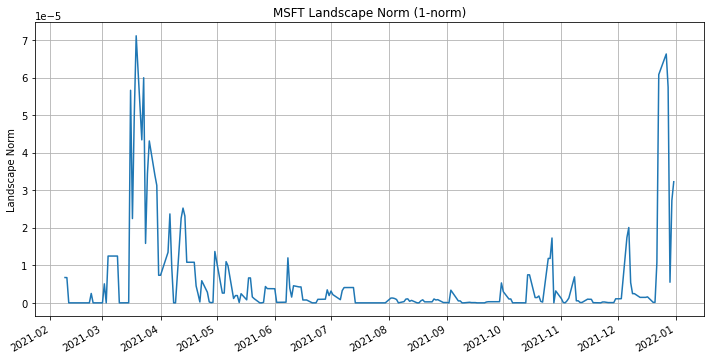

Calculating 1-norm...
Detecting spike signals (MA_WINDOW=20, OFFSET=4, SPIKE_THRESHOLD_PCT_ABOVE_MA=200%)...

--- MSFT Early Warning System Analysis ---
Average 10-period log return after signal: 0.0236

Signals Detected (first 5 rows):
            log_return  landscape_norm  signal  future_log_return_after_signal
2021-03-17   -0.002823    2.244021e-05       1                       -0.024961
2021-06-09    0.004030    3.938843e-06       1                        0.049964
2021-08-17   -0.005173    3.176258e-09       1                        0.031972
2021-09-07   -0.003193    5.136387e-07       1                       -0.022975
2021-10-01    0.025149    2.979550e-06       1                        0.071284


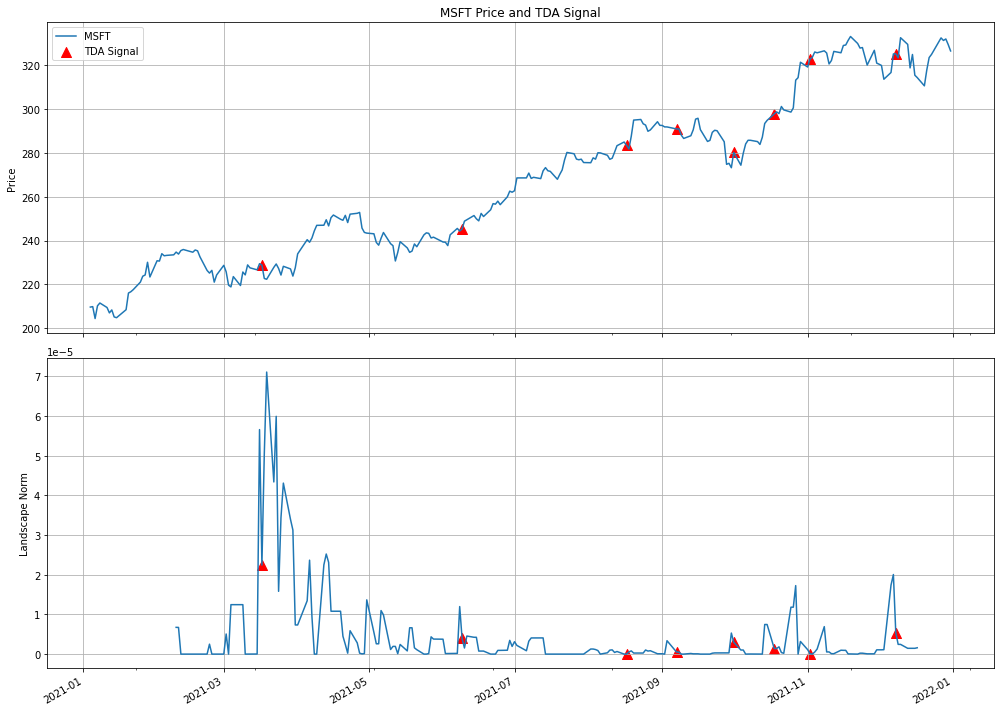


--- MSFT Backtesting ---


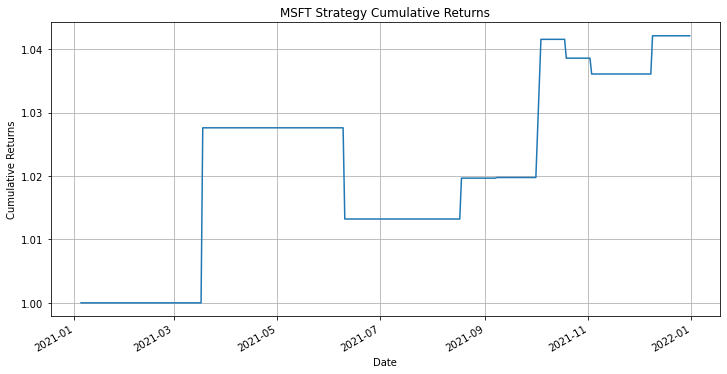


Performance Metrics:
Total Return: 0.0421
CAGR: 0.0427
Sharpe Ratio: 1.0881
Max Drawdown: -0.0140
Calmar Ratio: 3.0541

--- Finished Analysis for MSFT ---


In [7]:
analyze_and_backtest_asset(
    asset_ticker="MSFT",
    start_date=date(2021, 1, 1),
    end_date=date(2022,1,1)
)

#### Discussion on MSFT Results:

We visually inspect the plot of the landscape norm for MSFT. An increasing trend of landscape norm, especially significant spikes, might be a signal. The backtesting results provide a quantitative measure of how well our simple strategy performs based on these signals in the test period, considering the defined transaction costs.

Recall that our algorithm enters a short position when a signal is generated. We see that our warning system performs well even when the overall trend of the asset is increasing. Even there are several false positives, the loss is relatively low.

#### Example 2: Hang Seng Index (HSI)


--- Starting Analysis for ^HSI ---


C:\Users\User\AppData\Local\Temp\ipykernel_4832\2416917904.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(asset_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


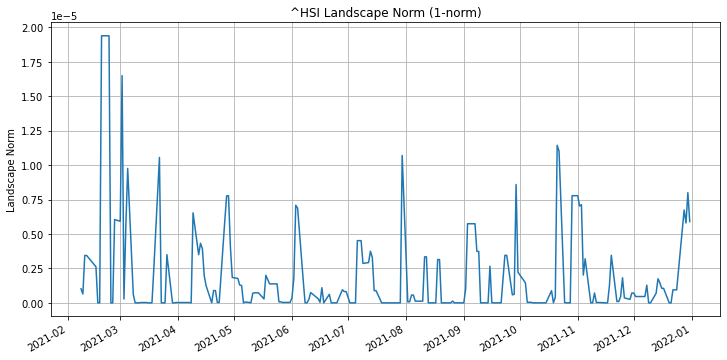

Calculating 1-norm...
Detecting spike signals (MA_WINDOW=20, OFFSET=4, SPIKE_THRESHOLD_PCT_ABOVE_MA=200%)...

--- ^HSI Early Warning System Analysis ---
Average 10-period log return after signal: -0.0088

Signals Detected (first 5 rows):
            log_return  landscape_norm  signal  future_log_return_after_signal
2021-04-12   -0.008592    3.495290e-06       1                        0.013152
2021-04-29    0.007946    4.099015e-06       1                       -0.029331
2021-06-04   -0.001656    6.876438e-06       1                       -0.005704
2021-07-09    0.007024    2.863505e-06       1                        0.020800
2021-08-02    0.010528    7.494398e-08       1                        0.016450


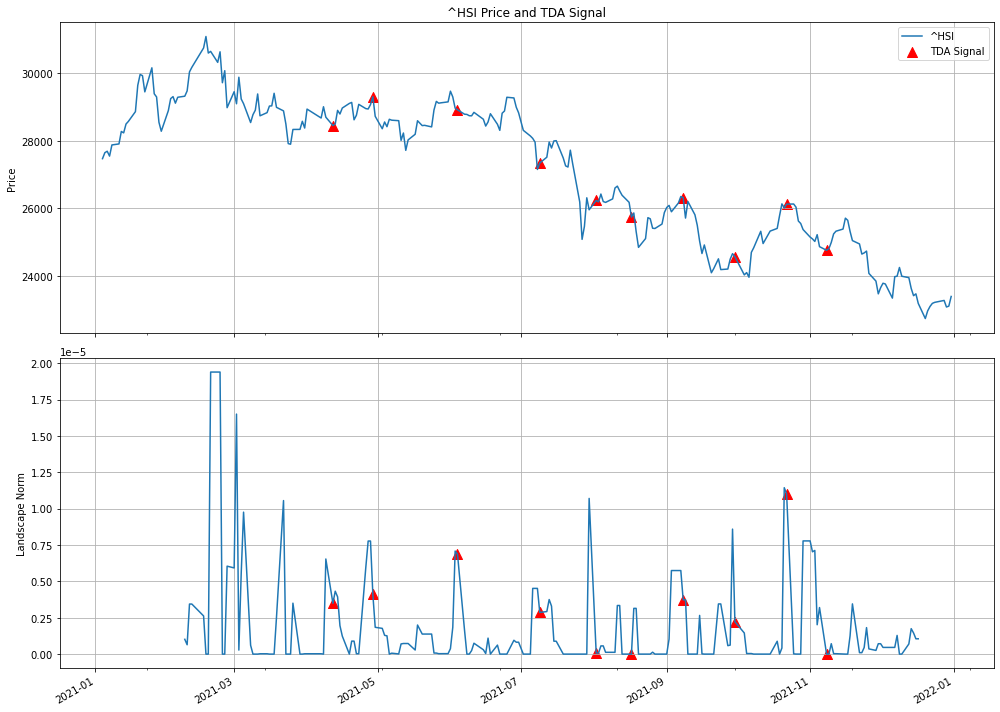


--- ^HSI Backtesting ---


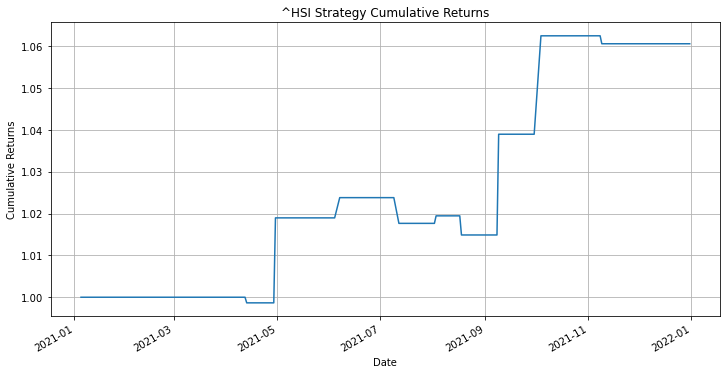


Performance Metrics:
Total Return: 0.0606
CAGR: 0.0615
Sharpe Ratio: 1.5265
Max Drawdown: -0.0087
Calmar Ratio: 7.0558

--- Finished Analysis for ^HSI ---


In [8]:
analyze_and_backtest_asset(
    asset_ticker="^HSI",
    start_date=date(2021, 1, 1),
    end_date=date(2022, 1, 1)
)

#### Discussion on HSI Results:

Similar to MSFT, we would observe the HSI landscape norm for spikes and trends. Our strategy performs even better in this situation, and we can even roughly corresponds each significant drop in HSI to the spikes in the landscape.